Using [tomeichlersmith/jupyter-scikit-hep](https://github.com/tomeichlersmith/jupyter-scikit-hep)
# hpstr Ana
Analysis of hpstr histograms.

## Notes
- `event_h` holds the total number of events processed
- `vtxana_vtxSelection/vtxana_vtxSelection_cutflow` shows number of events left after the cuts implemented via the selection infractructure
  - the number in the `no-cuts` bin of this histogram may not match the number in `event_h` since some events are skipped before the selections start
- production calculation stays the same from gen-level studies, the only thing changing is the fraction surviving after readout/selection
- out of the surviving events, we could cut out a specific displacement to align with a choice of mchi and epsilon

In [12]:
import uproot
import matplotlib.pyplot as plt

In [66]:
f = uproot.open('rmap-3.00-rdmchi-0.60/idm_2pt3_mchi_020_rmap_3.00_rdmchi_0.60.root')

In [3]:
f.keys(recursive=False)

['event_h;1', 'vtxana_vtxSelection;1', 'vtxana_mc_vtxSelection;1']

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f1a8614d290>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f1a86429110>, text=[])

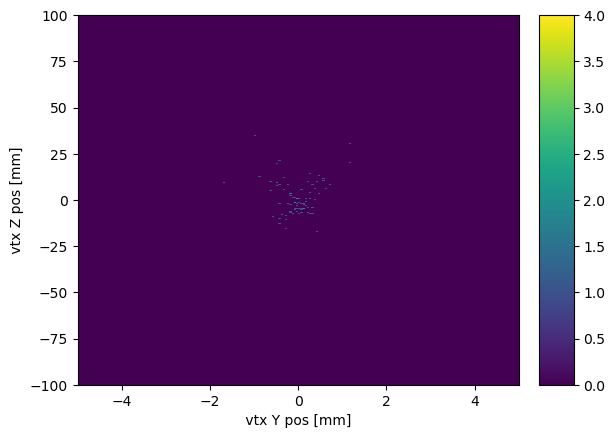

In [69]:
f['vtxana_vtxSelection/vtxana_vtxSelection_vtx_svt_y_svt_z_hh'].to_hist().plot()

In [5]:
f['event_h'].to_hist()

Hist(Regular(21, -10.5, 10.5, name='xaxis'), storage=Double()) # Sum: 229.0

In [26]:
h =  f['vtxana_vtxSelection/vtxana_vtxSelection_cutflow'].to_hist()

In [101]:
h.sum()

WeightedSum(value=1429, variance=1429)

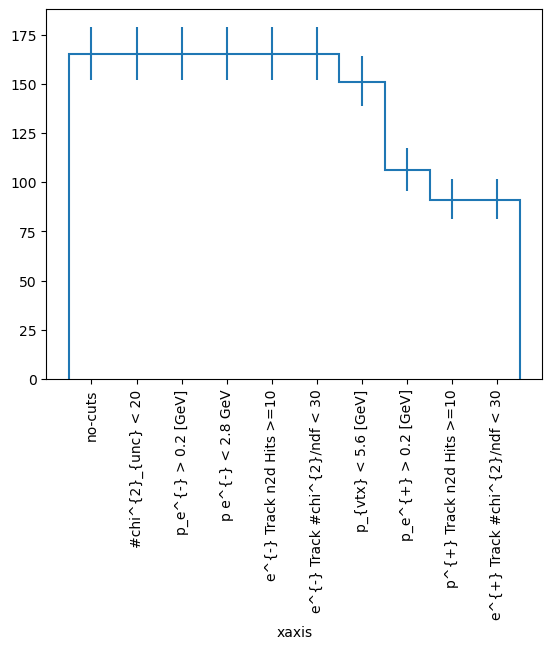

In [27]:
h.plot()
plt.xticks(
    #ticks = plt.gca().get_xticks(),
    #labels = [f'${l.get_text()}$' for l in plt.gca().get_xticklabels()],
    rotation=90
)
plt.show()

In [89]:
from pathlib import Path
import pandas as pd
import numpy as np
import uproot
import awkward as ak
import hist

def params_from_path(p: Path):
    params = p.stem.split('_')
    params = {params[i]:params[i+1] for i in range(0,len(params),2)}
    params['filepath'] = p
    return params


lumi = 10.7 # pb^{-1}
inverse_alpha = 137

def radFrac(mass):
    """total radiative fraction polynomial fit to MC distributions

    calculated by Alic Spellman for 2016 SIMPs using KF tracking on 11/15/22
    """
    radF = -1.04206e-01 \
         + 9.92547e-03*mass \
         + -1.99437e-04*pow(mass, 2) \
         + 1.83534e-06*pow(mass, 3) \
         + -7.93138e-9*pow(mass, 4) \
         + 1.30456e-11*pow(mass, 5)
    return radF

def totRadAcc(mass):
    """Total radiative acceptance polynomial fit to MC distributions

    calculated by Alic Spellman for 2016 SIMPs using KF tracking on 11/15/22
    """
    acc = -7.35934e-01 \
        + 9.75402e-02*mass \
        - 5.22599e-03*pow(mass, 2) \
        + 1.47226e-04*pow(mass, 3) \
        - 2.41435e-06*pow(mass, 4) \
        + 2.45015e-08*pow(mass, 5) \
        - 1.56938e-10*pow(mass, 6) \
        + 6.19494e-13*pow(mass, 7) \
        - 1.37780e-15*pow(mass, 8) \
        + 1.32155e-18*pow(mass, 9)
    return acc

def dNdm(mass, binwidth = 30.0):
    value = 0.0
    for name, pack in dNdm.__raw_data.items():
        t = pack['tree']
        value += ak.sum(
            (t['unc_vtx_mass']*1000 > mass - binwidth/2)&(t['unc_vtx_mass']*1000 < mass + binwidth/2)
        )*pack['scale']
    return value/binwidth

dNdm.__raw_data = {
    'tritrig': {
        'file': '../../simp-rate/final_hadd_tritrigv2-beamv6_2500kBunches_HPS-PhysicsRun2016-Pass2_v4_5_0_pairs1_976_KF_CR.root',
        'scale': 1.416e9*lumi/(50000*9853)
    },
    'wab': {
        'file': '../../simp-rate/final_hadd_wabv3-beamv6_2500kBunches_HPS-PhysicsRun2016-Pass2_v4_5_0_pairs1_KF_ana_CR.root',
        'scale': 0.1985e12*lumi/(100000*9966)
    }
}

for name, pack in dNdm.__raw_data.items():
    with uproot.open(pack['file']) as f:
        pack['tree'] = f['vtxana_kf_vertexSelection_Tight_CR/vtxana_kf_vertexSelection_Tight_CR_tree'].arrays()

def darkphoton_production(mass):
    if totRadAcc(mass) > 0:
        return (3*inverse_alpha/2)*np.pi*mass*radFrac(mass)*dNdm(mass)/totRadAcc(mass)
    else:
        return 0

In [152]:
samples = list(map(params_from_path, (Path.cwd() / 'rmap-3.00-rdmchi-0.60').iterdir()))
selection = hist.Hist(
    hist.axis.IntCategory(list(range(20,215,5)), name='mchi'),
    hist.axis.StrCategory(['pre-selection']+[a for a in h.axes[0]], name='cut'),
)

df = pd.DataFrame({
    'mchi': np.zeros(len(samples)),
    'npass': np.zeros(len(samples)),
    'ntota': np.zeros(len(samples)),
    'prod': np.zeros(len(samples))
})

for i, p in enumerate(samples):
    num_tota=10*1e5
    mchi = float(p['mchi'])
    with uproot.open(p['filepath']) as f:
        cuts = f['vtxana_vtxSelection/vtxana_vtxSelection_cutflow'].to_hist()
        npass = cuts[-1].value
        selection.fill(
            cut = list(cuts.axes[0]),
            mchi = int(mchi),
            weight = cuts.values()
        )
        selection.fill(
            cut = 'pre-selection',
            mchi = int(mchi),
            weight = f['event_h'].to_hist().sum()
        )
    df.iloc[i] = (
        mchi, 
        npass, 
        num_tota, 
        darkphoton_production(float(p['rmap'])*mchi)
    )
df['frac'] = df.npass/df.ntota
df['acc'] = df['frac']*df['prod']

In [168]:
def is_math(p):
    return '_' in p or '^' in p or '/' in p or '>' in p or '<' in p or '=' in p or p.isdigit()

def rootex_to_latex(label):
    parts = label.replace('#','\\').split()
    im = [is_math(p) for p in parts]
    newlabel = ''
    for i, p in enumerate(parts):
        if im[i] and (i==0 or not im[i-1]):
            p = '$'+p
        if im[i] and (i==len(parts)-1 or not im[i+1]):
            p = p + '$'
        newlabel += p+' '
    return newlabel.strip()

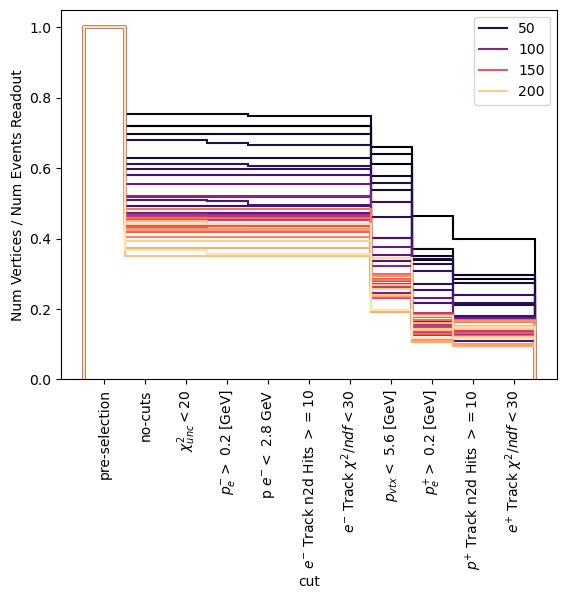

In [171]:
fig, ax = plt.subplots()
cm = plt.get_cmap('magma')
ax.set_prop_cycle(color=[cm(1.*i/len(selection.axes[0])) for i in range(len(selection.axes[0]))])
for mchi in selection.axes[0]:
    mchi_sl = selection[complex(0,mchi),:].project('cut')
    if mchi_sl[0] == 0:
        continue
    mchi_sl /= mchi_sl[0]
    mchi_sl.plot(
        ax=ax, 
        label=mchi if mchi % 50 == 0 else '_no_legend',
    )
ax.legend()
ax.set_xticks(
    ax.get_xticks(),
    labels = [rootex_to_latex(l.get_text()) for l in ax.get_xticklabels()],
    rotation=90
)
ax.set_ylabel('Num Vertices / Num Events Readout')
plt.show()

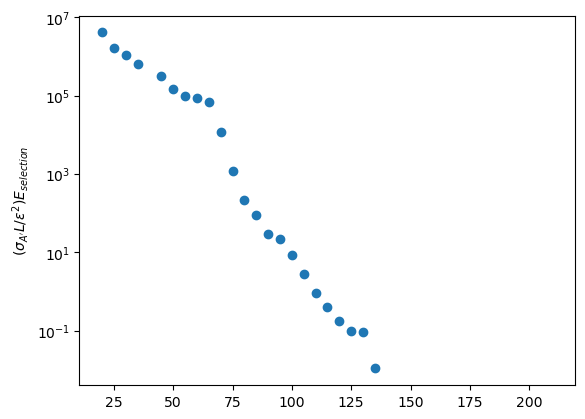

In [151]:
plt.scatter(df.mchi, df.acc)
plt.yscale('log')
plt.ylabel('$(\sigma_{A\'} L / \\epsilon^2) E_{selection}$')
plt.show()